## Deep Learning & Image Classification Setup
### Importing Libraries 

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import sklearn
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

2025-04-18 11:35:09.479753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744976109.734729      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744976109.803324      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Paths and Directory Setup

In [2]:
images_dir = "/kaggle/input/skin-dataset/skin/HAM10000_data"
csv_path = "/kaggle/input/skin-dataset/skin/HAM10000_metadata.csv"
data_images_dir='/kaggle/working/Images'
data_images_tmp='/kaggle/working/tmp'


## Hair Removal & Image Preprocessing
### To improve model performance on dermatoscopic images, this script removes hair artifacts using OpenCV techniques before saving the cleaned images to a temporary directory.

In [3]:
def preprocess(image):
    try:
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
        _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
        gaussian = cv2.GaussianBlur(final_image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
        return final_image
    except Exception as e:
        print(f"Error in hair removal: {str(e)}")
        return image


In [4]:
input_dir = images_dir
output_dir = data_images_tmp
os.makedirs(output_dir, exist_ok=True)

images = os.listdir(input_dir)

for image_name in tqdm(images):
    input_path = os.path.join(input_dir, image_name)
    output_path = os.path.join(output_dir, image_name)

    image = cv2.imread(input_path)

    if image is None:
        print(f"Failed to read: {input_path}")
        continue

    processed = preprocess(image)

    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    Image.fromarray(processed_rgb).save(output_path)


100%|██████████| 10015/10015 [08:49<00:00, 18.92it/s]


## Organizing Images by Class Labels
### Images are organized into directories named after their diagnostic class (`dx`) for easier loading with image generators or datasets.

In [5]:

%system rm -rf $data_images_dir
%system mkdir $data_images_dir

df = pd.read_csv(csv_path)
    
for _, row in df.iterrows():
    image_id = row["image_id"] + ".jpg" 
    class_name = row["dx"]
    
    class_dir = os.path.join(data_images_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    src_path = os.path.join(data_images_tmp, image_id)
    dst_path = os.path.join(class_dir, image_id)
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("Images have been successfully organized into class directories!")

Images have been successfully organized into class directories!


## Handling Class Imbalance: Class Weights

In [6]:
class_labels = np.unique(df["dx"])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=df["dx"]
)

class_wt_dict = dict(enumerate(class_weights))
class_wt_dict_labels = dict(zip(class_labels, class_weights))

print(class_wt_dict)
print(class_wt_dict_labels)

{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}
{'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


## Image Data Augmentation 
-  Preprocessing based on base model (EfficientNetV2)
-  Random rotation 
-  Horizontal shift 
-  Vertical shift 
-  Shear transformation
-  Random zoom
-  Random brightness adjustment
-  Small changes in RGB channels
-  Random horizontal flips
-  Fill strategy for empty pixels after transformations
-  15% of data reserved for validation

In [7]:
image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               brightness_range=[0.9,1.1],
                               channel_shift_range=0.05,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.15)

## Data Generators for Training and Validation

In [8]:
batch_size = 32
target_size = (299,299)
train_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Visualizing a Sample Image from the Training Generator

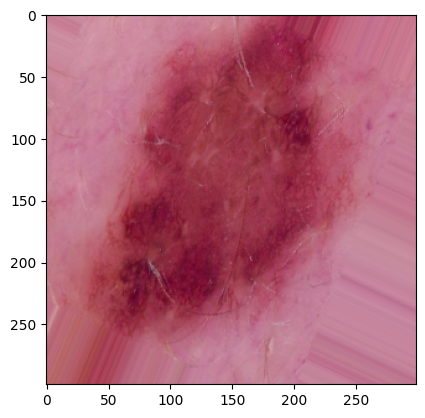

In [11]:
plt.imshow(train_image_gen[0][0][0]/255)

## Model Architecture: Transfer Learning with Xception

### We leverage **Xception**, a highly efficient and high-performing convolutional neural network, pretrained on ImageNet. The base is extended with a custom classification head tailored for the 7 skin lesion categories in the HAM10000 dataset.

In [12]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable=True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1744920512.608787      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744920512.609505      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Summary: Xception + Custom Classifier

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 21,859,631 (83.39 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Model Compilation

In [14]:
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Callbacks for Efficient Training

In [15]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,mode='max', min_lr=0.00000001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce,early_stop]

## Training the Model

In [16]:
%%time
history = model.fit(train_image_gen,
                    epochs=30, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744920557.820896     118 service.cc:148] XLA service 0x7a8b68021750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744920557.821802     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744920557.821822     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744920561.066972     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-17 20:09:27.310708: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,14

 11/267 ━━━━━━━━━━━━━━━━━━━━ 3:12 751ms/step - accuracy: 0.2256 - loss: 10.0928

2025-04-17 20:10:13.637649: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[4,256,74,74]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,74,74]{3,2,1,0}, f32[256,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-17 20:10:14.226955: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.589428994s
Trying algorithm eng3{k11=0} for conv (f32[4,256,74,74]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,74,74]{3,2,1,0}, f32[256,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_resu

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.4086 - loss: 9.1630

2025-04-17 20:14:45.817212: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[27,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-17 20:14:47.246031: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.428874292s
Trying algorithm eng3{k11=0} for conv (f32[27,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone


Epoch 1: val_accuracy improved from -inf to 0.71581, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.4090 - loss: 9.1595 - val_accuracy: 0.7158 - val_loss: 6.5377 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6757 - loss: 6.0858
Epoch 2: val_accuracy improved from 0.71581 to 0.76451, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 272s 997ms/step - accuracy: 0.6757 - loss: 6.0841 - val_accuracy: 0.7645 - val_loss: 4.7050 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7414 - loss: 4.2748
Epoch 3: val_accuracy improved from 0.76451 to 0.82588, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 272s 1000ms/step - accuracy: 0.7414 - loss: 4.2737 - val_accuracy: 0.8259 - val_loss: 3.3224 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.7908 - loss: 3.0105
Epoch 4: val_accuracy did 

## Plotting Training and Validation Loss

<Axes: >

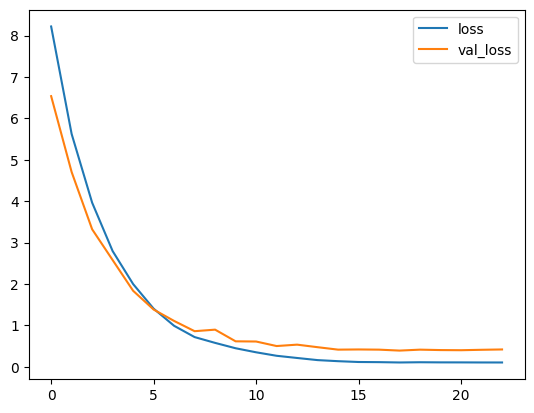

In [17]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

## Plotting Training and Validation Accuracy

<Axes: >

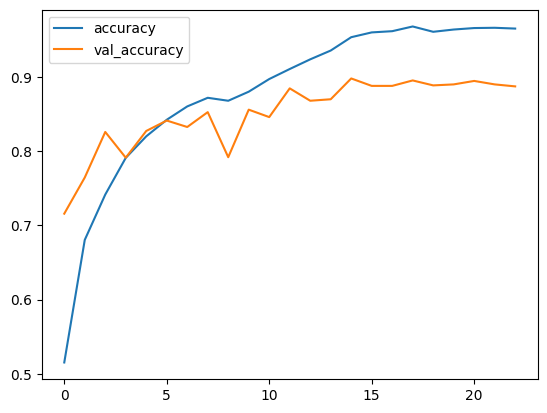

In [18]:
metrics[["accuracy","val_accuracy"]].plot()

## Model Evaluation

In [11]:
model.evaluate(test_image_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744976735.919760     114 service.cc:148] XLA service 0x78277400a880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744976735.923189     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744976735.923216     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744976736.509574     114 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-18 11:45:41.531999: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,14

47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 937ms/step - accuracy: 0.8368 - loss: 0.6125


[0.42017289996147156, 0.8872581720352173]

## Making Predictions and Evaluating Model Output

In [12]:
y_score = model.predict(test_image_gen, verbose=1)
predictions = y_score.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 748ms/step


## Confusion Matrix

In [13]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[ 35   5   5   0   3   1   0]
 [  2  73   0   0   1   1   0]
 [  5   0 128   4  13  14   0]
 [  1   1   0  14   0   1   0]
 [  5   3  14   1 105  37   1]
 [  3   5  16   3  32 946   0]
 [  0   0   0   1   0   1  19]]


## Normalized Confusion Matrix

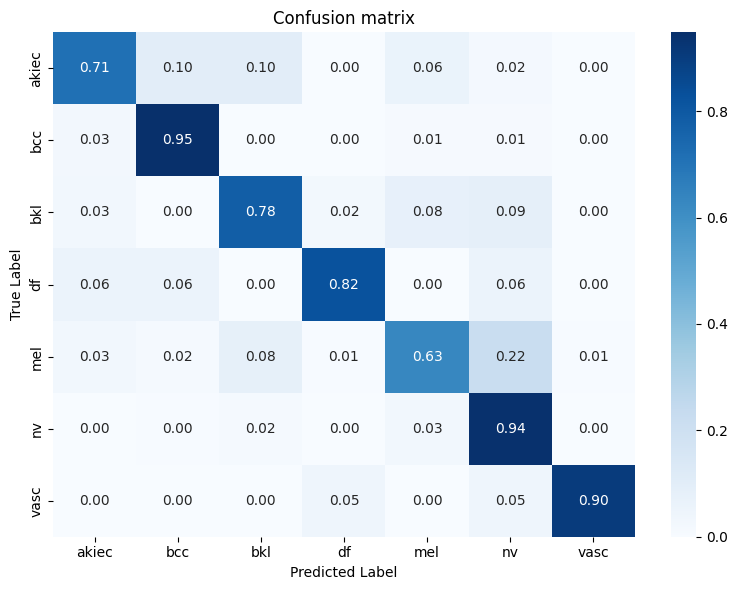

In [14]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes=list(test_image_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Classification Report

In [15]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70        49
           1       0.84      0.95      0.89        77
           2       0.79      0.78      0.78       164
           3       0.61      0.82      0.70        17
           4       0.68      0.63      0.66       166
           5       0.95      0.94      0.94      1005
           6       0.95      0.90      0.93        21

    accuracy                           0.88      1499
   macro avg       0.79      0.82      0.80      1499
weighted avg       0.88      0.88      0.88      1499



## ROC AUC Score Calculation for Multi-class Classification

In [16]:
class_names = list(test_image_gen.class_indices.keys())
n_classes = len(class_names)

y_test_bin = label_binarize(test_labels, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    print(f"ROC AUC Score for Class {class_names[i]}: AUC = {roc_auc[i]:.4f}")

ROC AUC Score for Class akiec: AUC = 0.9835
ROC AUC Score for Class bcc: AUC = 0.9980
ROC AUC Score for Class bkl: AUC = 0.9624
ROC AUC Score for Class df: AUC = 0.9972
ROC AUC Score for Class mel: AUC = 0.9516
ROC AUC Score for Class nv: AUC = 0.9753
ROC AUC Score for Class vasc: AUC = 0.9997


## Plot ROC AUC  curves for all classes

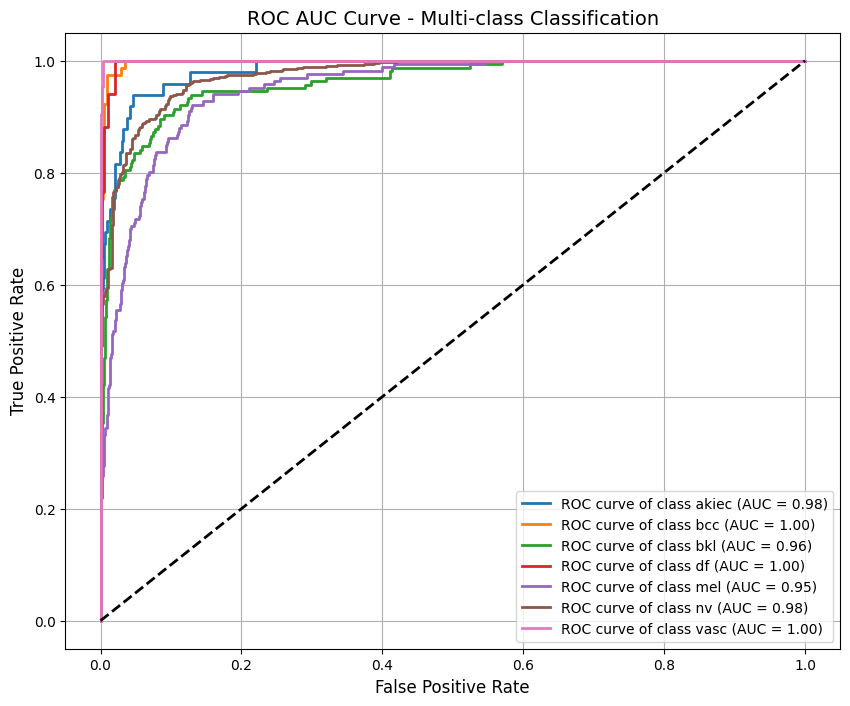

In [17]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC AUC Curve - Multi-class Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## Plot Precision-Recal curves for all classes

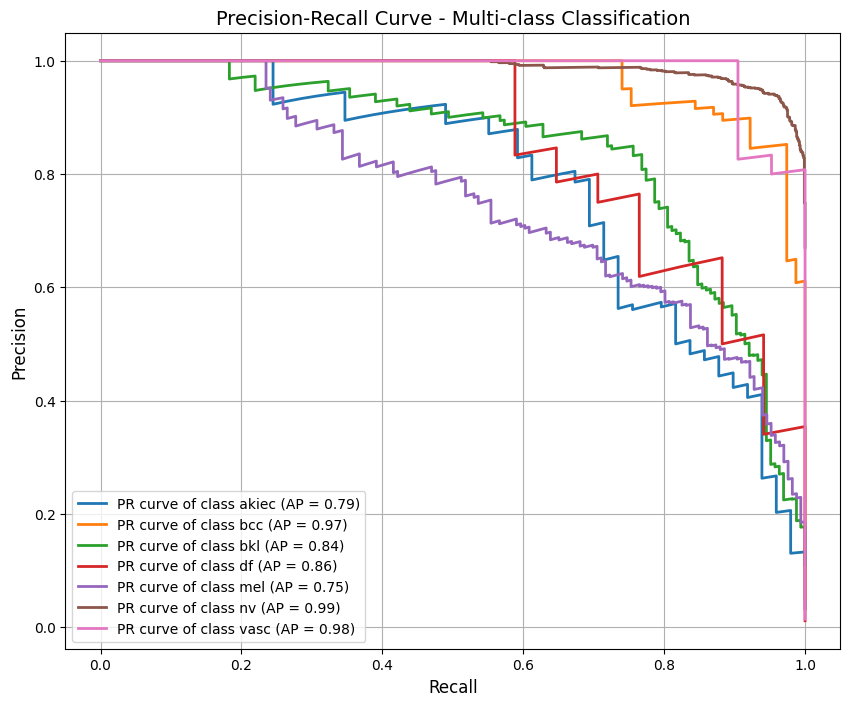

In [18]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Multi-class Classification", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()